# "S3 partners short interest dataset initial analysis"
> "First impressions and Exploratory Data Analysis of S3 partners short interest dataset"
- toc: true
- branch: master
- badges: true
- comments: true
- author: Sylvain Thibault
- categories: [Datasets, S3 Partners, EDA]

## S3 partners short interest
Short interest is usually measured by shares on loan.
Some brokers don't rely on borrowing shares as they have shares in inventory.

eg russell 3000


In their promotional presentation, S3 states:

- stock borrowed data is 45% within 10% of actual reported
- S3 data is 85% within 10% of actual reported

*Common Short Float = shares shorted / shares available to trade*

*Despite its widespread use, this calculation is flawed in two main ways:*

*US investors are only required to report short shares twice per month, leading to a short interest number being roughly ten days stale by the time it gets to investors
Float does not accurately represent shares available to trade on a daily basis
To combat these flaws, S3 provides a true daily shares shorted measure and calculates more accurate “tradeable shares” than the general definition for Float provides.*

*S3 points out that “what is missing [from the general definition for float] are the ‘synthetic longs’ that are created as a result of a short sale which, in some stocks, can be a very significant number.” The synthetic long is a result of a long shareholder lending out their shares, a short seller borrowing those shares, and a long buyer on the other side of the short sale now owning the shares. In this case, the long buyer on the other side of the short sale has increased the market’s potential tradable quantity of shares.
The interesting feature in the S3 data is the Squeeze Risk which we will look in depth.*


## S3 Data Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import liberator
from datetime import datetime, timedelta

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 40)

In [3]:
#
# S3 data as of December 23rd US stock only
df_s3_21_us = pd.read_csv('df_s3_23dec21_us.csv', dtype={"Cusip":"string"});


In [4]:
print(f"S3 short float mean: {df_s3_21_us['S3SIPctFloat'].mean():.3f}")
print(f"S3 short max: {df_s3_21_us['S3SIPctFloat'].max()}")
print(f"S3 short median: {df_s3_21_us['S3SIPctFloat'].median()}")
print(f"S3 short skew: {df_s3_21_us['S3SIPctFloat'].skew():.3f}")

S3 short float mean: 0.035
S3 short max: 1.0
S3 short median: 0.0013
S3 short skew: 6.248


In [9]:
df_s3_21_us.iloc[:,7:].head()

,BBGID,Name,Offer Rate,Bid Rate,Last Rate,Short Momentum,Short Interest,ShortInterestNotional,ShortInterestPct,S3Float,S3SIPctFloat,IndicativeAvailability,Utilization,DaysToCover10Day,DaysToCover30Day,DaysToCover90Day,Crowded Score,Squeeze Risk,symbol
0,FLWS US,1-800-FLOWERS.COM,0.30,0.15,0.30,0.0,7146702.0,1.858143e+08,0.2628,34338966.0,0.2081,1010980.0,NaN,10.339198,10.152532,8.014981,72.5,82.5,FLWS
1,VCVCU US,10X Capital Venture Acquisition Corp...,0.83,0.53,0.30,0.0,22353.0,2.380595e+05,0.0011,19729035.0,0.0011,5906030.0,NaN,0.281057,0.064992,0.064992,5.0,5.0,VCVCU
2,TXG US,10X GENOMICS INC,0.30,0.15,0.30,0.0,960805.0,1.360500e+08,0.0157,62019955.0,0.0155,17396300.0,NaN,1.244221,1.140568,1.185829,10.0,10.0,TXG
3,YI US,111 INC,0.95,0.61,0.30,-4.3,59512.0,4.136084e+05,0.0013,46418902.0,0.0013,13848300.0,NaN,0.184862,0.379655,0.437930,5.0,5.0,YI
4,YSGG US,1399 Internet Technology Application...,3.58,2.53,3.75,1.5,398.0,2.208900e+02,0.0031,128398.0,0.0031,30322.0,NaN,3.289256,0.802419,1.922705,10.0,0.0,YSGG


- Crowding: S3’s proprietary index score measuring the magnitude of shorting/covering activity relative to the security’s float, borrow capacity and financing rate.


- Short Interest: Real-time short interest expressed in shares.


- ShortInterestNotional: ShortInterest * Price (USD)


- ShortInterestPct:	Real-time short interest as a percentage of equity float.


- S3Float:	The number of tradable shares including synthetic longs created by short selling.


- S3SIPctFloat:	Real-time short interest projection divided by the S3 float.


- IndicativeAvailability:	S3's projected available lendable quantity


- Utilization:	S3's Utilization is defined as S3 Short Interest divided by Total Lendable supply


- DaysToCover10Day:	Liquidity measure = Short Interest / 10 day average ADTV


- DaysToCover30Day:	Liquidity measure = Short Interest / 30 day average ADTV


- DaysToCover90Day:	Liquidity measure = Short Interest / 90 day average ADTV

Finviz scan for tradable stock universe with volume > 500k, price > 10$ and ATR > 0.5

In [10]:
#
# average volume > 500k, price > 10$, ATR > 0.5
df_finviz = pd.read_csv('finviz_dec_23.csv')

In [11]:
df_finviz.head()

,No.,Ticker,Company,Sector,Industry,Country,Market Cap,P/E,Shares Float,Float Short,Short Ratio,Average True Range,Volatility (Week),Volatility (Month),Relative Strength Index (14),Average Volume,Price,Change,Volume
0,1,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,47573.54,39.97,302.58,1.44%,2.78,4.13,2.22%,2.73%,55.64,1566.50,157.80,0.65%,1409105
1,2,AA,Alcoa Corporation,Basic Materials,Aluminum,USA,10870.60,13.82,184.14,5.28%,1.13,2.79,5.31%,5.45%,71.62,8625.14,59.36,0.08%,7509823
2,3,AAL,American Airlines Group Inc.,Industrials,Airlines,USA,11523.70,NaN,641.17,15.42%,2.84,0.92,5.21%,5.62%,51.22,34775.22,18.26,0.00%,32205886
3,4,AAP,"Advance Auto Parts, Inc.",Consumer Cyclical,Specialty Retail,USA,14867.93,23.49,62.08,4.89%,4.77,5.68,1.94%,2.36%,50.53,636.40,232.13,-0.28%,492798
4,5,AAPL,Apple Inc.,Technology,Consumer Electronics,USA,2911047.36,31.44,16394.79,0.69%,1.25,4.74,1.91%,2.78%,62.88,89972.33,176.28,0.36%,68138164


In [12]:
# 1294 stocks
df_finviz.shape

(1294, 19)

Lets extract S3 data for december 23rd to compare with the Finviz data for that day

In [13]:
# extract s3 data for dec 23, the day of our finviz screen
df_s3_dec_23 = df_s3_21_us[df_s3_21_us['timestamp'].str.startswith('2021-12-23')]


In [14]:
# filter s3 data for our target stocks from finviz
df_s3_dec23_filtered = df_s3_dec_23[df_s3_dec_23.symbol.isin(df_finviz.Ticker)]
df_s3_dec23_filtered.head()

,_seq,timestamp,muts,Business Date,Sedol,ISIN,Cusip,BBGID,Name,Offer Rate,Bid Rate,Last Rate,Short Momentum,Short Interest,ShortInterestNotional,ShortInterestPct,S3Float,S3SIPctFloat,IndicativeAvailability,Utilization,DaysToCover10Day,DaysToCover30Day,DaysToCover90Day,Crowded Score,Squeeze Risk,symbol
4809929,13,2021-12-23 00:00:00.000,1640235600000000,12/23/2021,2444123,US68243Q1067,<NA>,FLWS US,1-800-FLOWERS.COM,0.3,0.15,0.44,0.0,4525039.0,1.007274e+08,0.1608,32668564.0,0.1385,9044225.0,NaN,4.17,6.81,8.86,52.5,32.5,FLWS
4809933,18,2021-12-23 00:00:00.000,1640235600000000,12/23/2021,BKS3RS7,US88025U1097,<NA>,TXG US,10X GENOMICS INC,0.3,0.15,0.30,0.0,3119063.0,4.563813e+08,0.0378,85584279.0,0.0364,32485436.0,NaN,5.04,3.79,4.62,25.0,35.0,TXG
4809947,37,2021-12-23 00:00:00.000,1640235600000000,12/23/2021,BKMG1N5,US68269G1076,<NA>,ONEM US,1LIFE HEALTHCARE INC,0.3,0.15,0.32,0.0,11572770.0,1.980101e+08,0.0817,153159369.0,0.0756,42193022.0,NaN,4.41,4.44,5.86,32.5,22.5,ONEM
4809953,48,2021-12-23 00:00:00.000,1640235600000000,12/23/2021,2341439,US3208671046,<NA>,FMBI US,1ST MIDWEST BANCORP,0.3,0.15,0.30,0.0,2078927.0,4.137065e+07,0.0184,114859045.0,0.0181,59276849.0,NaN,2.40,3.23,3.98,12.5,12.5,FMBI
4809969,73,2021-12-23 00:00:00.000,1640235600000000,12/23/2021,BMTXV88,US9013841070,<NA>,TSVT US,2seventy Bio Inc.,0.3,0.15,0.31,0.0,924742.0,2.906464e+07,0.0405,23784666.0,0.0389,8079652.0,NaN,1.46,1.77,1.75,12.5,22.5,TSVT


Top 10 stocks by S3 Squeeze Risk for December 23

In [15]:
# top 10 s3 for squeeze risk on december 23
s3_top10 = df_s3_dec23_filtered.nlargest(10, 'Squeeze Risk')[['symbol','ShortInterestPct','S3SIPctFloat','Crowded Score','Squeeze Risk']]
s3_top10

,symbol,ShortInterestPct,S3SIPctFloat,Crowded Score,Squeeze Risk
4812347,BFRI,0.8828,0.4689,80.0,100.0
4814459,CRTX,0.5510,0.3553,85.0,100.0
4818535,HRTX,0.3298,0.2480,80.0,100.0
4819384,ICPT,0.3583,0.2638,82.5,100.0
4824790,PRLD,0.3444,0.2562,82.5,100.0
4811269,ARCH,0.2729,0.2144,75.0,95.0
4817755,GOGO,0.3251,0.2453,82.5,92.5
4825582,RLAY,0.1957,0.1637,72.5,92.5
4820441,JAMF,0.2026,0.1685,60.0,90.0
4827953,TTCF,0.3294,0.2478,90.0,90.0


In [16]:
# add new column 'fshortn' with Float short as a float
df_finviz['fshortn'] = df_finviz['Float Short'].str.replace('%','').astype(float)

In [17]:
# top 20 finviz Float Short
finviz_top20 = df_finviz.nlargest(20,'fshortn')[['Ticker','Shares Float','Float Short']]
finviz_top20

,Ticker,Shares Float,Float Short
150,BFRI,3.60,84.91%
299,CRTX,20.02,45.87%
687,LGVN,2.91,42.40%
1152,TTCF,41.42,39.05%
173,BLNK,36.34,34.35%
601,ICPT,24.38,34.23%
693,LMND,39.98,34.01%
201,BYND,56.50,33.96%
584,HRTX,101.77,30.89%
152,BGFV,20.86,27.91%


In [18]:
# function to get common elements in 2 lists
def Intersection(lst1, lst2):
    return set(lst1).intersection(lst2)

How many of our top 10 Squeeze Risk stocks are caught with a Finviz top 20 short float for December 23?

In [19]:
# see what symbols from top 10 float short in S3 are in finviz top 20
Intersection(s3_top10.symbol, finviz_top20.Ticker)

{'ARCH', 'BFRI', 'CRTX', 'HRTX', 'ICPT', 'RLAY', 'TTCF'}

The top 20 float short stocks from finviz catch 7/10 of the top Squeeze Risk S3 stocks.

In [20]:
# top 10 s3 for Short Interest Pct on december 23
s3_SIP_top10 = df_s3_dec23_filtered.nlargest(10, 'ShortInterestPct')[['symbol','ShortInterestPct','S3SIPctFloat','Crowded Score','Squeeze Risk']]
s3_SIP_top10

,symbol,ShortInterestPct,S3SIPctFloat,Crowded Score,Squeeze Risk
4812347,BFRI,0.8828,0.4689,80.0,100.0
4814459,CRTX,0.5510,0.3553,85.0,100.0
4821599,LGVN,0.3869,0.2789,80.0,60.0
4813317,SAVA,0.3729,0.2716,80.0,60.0
4811926,BKKT,0.3609,0.2652,85.0,25.0
4819384,ICPT,0.3583,0.2638,82.5,100.0
4812522,BLNK,0.3522,0.2605,80.0,50.0
4824790,PRLD,0.3444,0.2562,82.5,100.0
4821303,LMND,0.3427,0.2552,87.5,87.5
4818535,HRTX,0.3298,0.2480,80.0,100.0


Looking at the short interest values, we can see that some stocks with similar short float value have very different Squeeze Risk.  So the proprietary Squeeze Risk data has different information in it.

How many top 10 S3 short float value do we catch with the finviz top 20 ?

In [21]:
# see what symbols from top 10 float short in S3 are in finviz top 20
Intersection(s3_SIP_top10.symbol, finviz_top20.Ticker)

{'BFRI', 'BLNK', 'CRTX', 'HRTX', 'ICPT', 'LGVN', 'LMND', 'SAVA'}

The top 20 float short stocks from finviz for dec 23 catch 8/10 of the top Short Interest Pct S3 stocks.

In [22]:
# lets merge finviz data our S3 data
merge_df = pd.merge(df_finviz, df_s3_dec23_filtered[['symbol','ShortInterestPct','S3SIPctFloat','Squeeze Risk']],left_on='Ticker',right_on='symbol')
merge_df.head()

,No.,Ticker,Company,Sector,Industry,Country,Market Cap,P/E,Shares Float,Float Short,Short Ratio,Average True Range,Volatility (Week),Volatility (Month),Relative Strength Index (14),Average Volume,Price,Change,Volume,fshortn,symbol,ShortInterestPct,S3SIPctFloat,Squeeze Risk
0,1,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,47573.54,39.97,302.58,1.44%,2.78,4.13,2.22%,2.73%,55.64,1566.50,157.80,0.65%,1409105,1.44,A,0.0151,0.0148,22.5
1,2,AA,Alcoa Corporation,Basic Materials,Aluminum,USA,10870.60,13.82,184.14,5.28%,1.13,2.79,5.31%,5.45%,71.62,8625.14,59.36,0.08%,7509823,5.28,AA,0.0538,0.0511,57.5
2,3,AAL,American Airlines Group Inc.,Industrials,Airlines,USA,11523.70,NaN,641.17,15.42%,2.84,0.92,5.21%,5.62%,51.22,34775.22,18.26,0.00%,32205886,15.42,AAL,0.1722,0.1469,67.5
3,4,AAP,"Advance Auto Parts, Inc.",Consumer Cyclical,Specialty Retail,USA,14867.93,23.49,62.08,4.89%,4.77,5.68,1.94%,2.36%,50.53,636.40,232.13,-0.28%,492798,4.89,AAP,0.0512,0.0487,32.5
4,5,AAPL,Apple Inc.,Technology,Consumer Electronics,USA,2911047.36,31.44,16394.79,0.69%,1.25,4.74,1.91%,2.78%,62.88,89972.33,176.28,0.36%,68138164,0.69,AAPL,0.0070,0.0070,27.5


Lets see how correlated S3 short float data is the Finviz equivalent

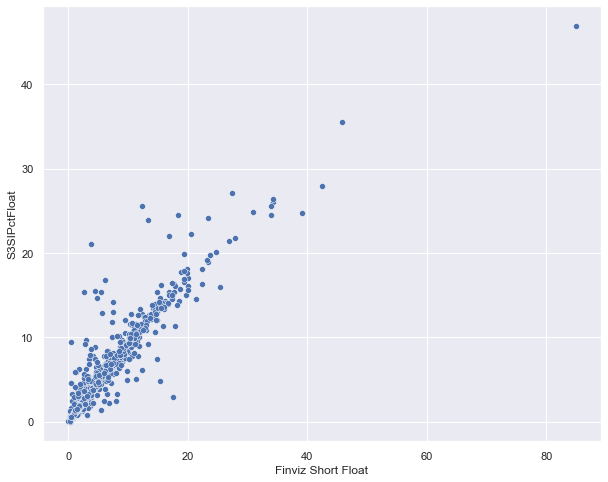

In [23]:
# Scatter plot of finviz Float Short versus S3 Squeeze Risk
sns.set(rc = {'figure.figsize':(10,8)})
sns.scatterplot(x=merge_df['fshortn'], y=merge_df['S3SIPctFloat']*100);
plt.xlabel("Finviz Short Float");

The S3 SIP percentage float values look to be highly correlated with the Finviz Short Float values and would not add anything to a model.  This is for one day but this was done for about 20 days with the same results.

In [24]:
print(f"correlation between S3 and Finviz short float: {merge_df['S3SIPctFloat'].corr(merge_df['fshortn']):.3f}")

correlation between S3 and Finviz short float: 0.933


This is highly correlated.  Anything above 0.8 is highly correlated.  A correlation that high would seem to indicate that based solely on the S3 percent Float data the gain in accuracy S3 advertises is not significant compared to Finviz Elite data.  Granted this was done for about 20 days with the same results.


The S3 metric we are really interested in is their proprietary Squeeze Risk.

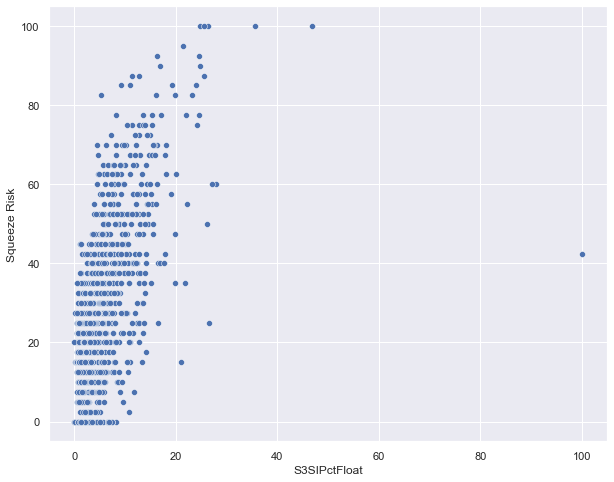

In [25]:
sns.scatterplot(x=merge_df['S3SIPctFloat']*100, y=merge_df['Squeeze Risk']);

In [26]:
print(f"correlation between S3 short float and S3 Squeeze Risk:\n{merge_df['S3SIPctFloat'].corr(merge_df['Squeeze Risk']):.3f}")

correlation between S3 short float and S3 Squeeze Risk:
0.615


S3 proprietary Squeeze Risk seem to have more information than just their percent float value, this looks more promising.

Lets look at S3 data correlation between data features.

In [27]:
target = ['Short Momentum',
 'Short Interest',
 'ShortInterestNotional',
 'ShortInterestPct',
 'S3Float',
 'S3SIPctFloat',
 'IndicativeAvailability',
 'DaysToCover10Day',
 'DaysToCover30Day',
 'DaysToCover90Day',
 'Crowded Score',
 'Squeeze Risk',
 'symbol']

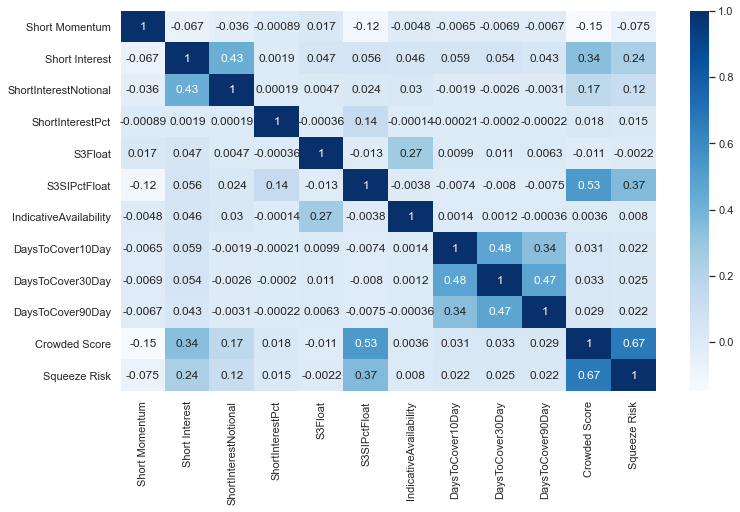

In [40]:
plt.figure(figsize=(12,7));
sns.heatmap(df_s3_21_us[target].corr(),annot=True,cmap='Blues');

This heatmap indicates that none of the S3 features are highly correlated together.  So in a model, every feature could be included and contribute to performance.

In [41]:
# lets filter our s3 data to our Finviz tradable stock universe
df_s3_21_us_filtered = df_s3_21_us.copy()
df_s3_21_us_filtered = df_s3_21_us_filtered[df_s3_21_us_filtered.symbol.isin(list(df_finviz.Ticker))]

In [42]:
df_s3_21_us_filtered.shape

(297388, 26)

In [43]:
# add timestamp date column
df_s3_21_us_filtered['Date'] = pd.to_datetime(df_s3_21_us_filtered.timestamp)
df_s3_21_us_filtered.iloc[:,7:].head()

,BBGID,Name,Offer Rate,Bid Rate,Last Rate,Short Momentum,Short Interest,ShortInterestNotional,ShortInterestPct,S3Float,S3SIPctFloat,IndicativeAvailability,Utilization,DaysToCover10Day,DaysToCover30Day,DaysToCover90Day,Crowded Score,Squeeze Risk,symbol,Date
0,FLWS US,1-800-FLOWERS.COM,0.3,0.15,0.3,0.0,7146702.0,1.858143e+08,0.2628,34338966.0,0.2081,1010980.0,NaN,10.339198,10.152532,8.014981,72.5,82.5,FLWS,2021-01-04
2,TXG US,10X GENOMICS INC,0.3,0.15,0.3,0.0,960805.0,1.360500e+08,0.0157,62019955.0,0.0155,17396300.0,NaN,1.244221,1.140568,1.185829,10.0,10.0,TXG,2021-01-04
14,ONEM US,1LIFE HEALTHCARE INC,0.3,0.15,0.3,0.0,8892859.0,3.881733e+08,0.1064,92461255.0,0.0962,16177700.0,NaN,10.620926,6.566751,5.781965,47.5,67.5,ONEM,2021-01-04
20,FMBI US,1ST MIDWEST BANCORP,0.3,0.15,0.3,0.0,3071098.0,4.889188e+07,0.0272,116034821.0,0.0265,30818000.0,NaN,3.148213,4.196131,4.725530,15.0,25.0,FMBI,2021-01-04
32,TWOU US,2U INC,0.3,0.15,0.3,0.0,12178811.0,4.872742e+08,0.1741,82125089.0,0.1483,8719930.0,NaN,10.451798,11.460037,9.689524,65.0,65.0,TWOU,2021-01-04


In [44]:
# set index to date
df_s3_21_us_filtered.index = df_s3_21_us_filtered['Date']
del df_s3_21_us_filtered['timestamp']
del df_s3_21_us_filtered['Date']
df_s3_21_us_filtered.head()

,_seq,muts,Business Date,Sedol,ISIN,Cusip,BBGID,Name,Offer Rate,Bid Rate,Last Rate,Short Momentum,Short Interest,ShortInterestNotional,ShortInterestPct,S3Float,S3SIPctFloat,IndicativeAvailability,Utilization,DaysToCover10Day,DaysToCover30Day,DaysToCover90Day,Crowded Score,Squeeze Risk,symbol
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,5,1609736400000000,01/04/2021,2444123,US68243Q1067,68243Q106,FLWS US,1-800-FLOWERS.COM,0.3,0.15,0.3,0.0,7146702.0,1.858143e+08,0.2628,34338966.0,0.2081,1010980.0,NaN,10.339198,10.152532,8.014981,72.5,82.5,FLWS
2021-01-04,9,1609736400000000,01/04/2021,BKS3RS7,US88025U1097,88025U109,TXG US,10X GENOMICS INC,0.3,0.15,0.3,0.0,960805.0,1.360500e+08,0.0157,62019955.0,0.0155,17396300.0,NaN,1.244221,1.140568,1.185829,10.0,10.0,TXG
2021-01-04,25,1609736400000000,01/04/2021,BKMG1N5,US68269G1076,68269G107,ONEM US,1LIFE HEALTHCARE INC,0.3,0.15,0.3,0.0,8892859.0,3.881733e+08,0.1064,92461255.0,0.0962,16177700.0,NaN,10.620926,6.566751,5.781965,47.5,67.5,ONEM
2021-01-04,35,1609736400000000,01/04/2021,2341439,US3208671046,320867104,FMBI US,1ST MIDWEST BANCORP,0.3,0.15,0.3,0.0,3071098.0,4.889188e+07,0.0272,116034821.0,0.0265,30818000.0,NaN,3.148213,4.196131,4.725530,15.0,25.0,FMBI
2021-01-04,53,1609736400000000,01/04/2021,BKWBZZ0,US90214J1016,90214J101,TWOU US,2U INC,0.3,0.15,0.3,0.0,12178811.0,4.872742e+08,0.1741,82125089.0,0.1483,8719930.0,NaN,10.451798,11.460037,9.689524,65.0,65.0,TWOU


Lets build a dataframe with the daily top 10 S3 Squeeze Risk with quote data including previous day close and previous day vwap.  On a given trading day open, one would have all of the S3 data, the Open price and the previous day's close and vwap.

In [45]:
# new dataframe with S3 and quote data
df_top10 = pd.DataFrame(columns=['date','symbol','Open','High','Low','Close','Volume','vwap','prev_close','prev_vwap','Offer Rate','Bid Rate','Last Rate','Short Momentum','Short Interest','ShortInterestNotional','ShortInterestPct','S3Float','S3SIPctFloat','IndicativeAvailability','DaysToCover10Day','DaysToCover30Day','DaysToCover90Day','Crowded Score','Squeeze Risk','squeeze_return','profitable'])

In [46]:
# build date array for 2021
# dates = list(set(list(df_s3_21_us_filtered.index)))
dates = np.unique(np.array(df_s3_21_us_filtered.index))
dates[:5]

array(['2021-01-04T00:00:00.000000000', '2021-01-05T00:00:00.000000000',
       '2021-01-06T00:00:00.000000000', '2021-01-07T00:00:00.000000000',
       '2021-01-08T00:00:00.000000000'], dtype='datetime64[ns]')

In [47]:
# for some reason S3 has data on Thanksgiving, November 25th which is a non trading day
index_to_remove = np.where(np.array([str(d) for d in dates]) == '2021-11-25T00:00:00.000000000')

In [48]:
# remove Thanksgiving
dates = np.delete(dates, index_to_remove)

In [49]:
# get date strings for liberator api
date_strings = [str(d)[:10] for d in dates]
date_strings = np.array(date_strings)

Loop to populate our dataframe.  As a rough POC, we add a profitable feature to indicate if a stock reach 10% or above its open price for that day.

So we are assuming a Squeeze occurs if the high for the day reaches 10% above the stock open.  This value should probably be higher but this is just a first exploration of the data.

In [38]:
index = 0
for d in dates[1:]:
    # print(d)
    # top 10 s3 for squeeze risk
    # top_10 = df_s3_21_us_filtered.loc[d].nlargest(10, 'Squeeze Risk')[['symbol','ShortInterestPct','S3SIPctFloat','Crowded Score','Squeeze Risk']]
    top_10 = df_s3_21_us_filtered.loc[d].nlargest(10, 'Squeeze Risk')[['symbol','Offer Rate','Bid Rate','Last Rate','Short Momentum','Short Interest','ShortInterestNotional','ShortInterestPct','S3Float','S3SIPctFloat','IndicativeAvailability','DaysToCover10Day','DaysToCover30Day','DaysToCover90Day','Crowded Score','Squeeze Risk']]
    top_10_symbols = list(top_10.symbol)
    date = str(d)[:10]
    # find index for current date
    date_index = np.where(date_strings == date)[0][0]
    # get index for previous trading day
    date_index -= 1
    end = str((pd.Timestamp(d) + timedelta(days=1)).date())
    # get quotes for top 10 Squeeze Risk symbols for current and previous date
    quotes = liberator.get_dataframe(liberator.query(symbols = top_10_symbols, as_of = end, back_to = date_strings[date_index], name = 'daily_bars'))
    # iterate through each top 10 stock for current day
    for dd, row in top_10.iterrows():
        # quote for symbol
        quote = quotes[quotes.symbol == row['symbol']]
        # no quote for symbol at this date, continue
        if quote.empty:
            print(f'{row["symbol"]} has no quotes for {date}')
            continue
        # current quote
        q = quote[quote.timestamp.str.startswith(date)]
        # previous trading day quote
        qprev = quote[~quote.timestamp.str.startswith(date)]
        
        high = q['high'].values[0]
        open = q['open'].values[0]
        # potential_return is max possible return from open
        potential_return = round((high - open)/high, 3)
        # print(q['symbol'] + ': ' + str(potential_return))
        row['date'] = date
        row['Open'] = open
        row['High'] = high
        row['Low'] = q['low'].values[0]
        row['Close'] = q['close'].values[0]
        row['Volume'] = q['volume'].values[0]
        row['vwap'] = q['vwap'].values[0]
        # prev trading day values
        row['prev_vwap'] = qprev['vwap'].values[0]
        row['prev_close'] = qprev['close'].values[0]
        # max potential return
        row['squeeze_return'] = potential_return
        # label profitable > 10%
        row['profitable'] = 1 if potential_return >= 0.1 else 0
        df_top10.loc[index] = row

        index+=1

SOFI has no quotes for 2021-02-05
PCT has no quotes for 2021-02-12
PCT has no quotes for 2021-02-16
SOFI has no quotes for 2021-04-09
SOFI has no quotes for 2021-04-12
SOFI has no quotes for 2021-04-29
SOFI has no quotes for 2021-04-30
SOFI has no quotes for 2021-05-03
SOFI has no quotes for 2021-05-04
SOFI has no quotes for 2021-05-05
SOFI has no quotes for 2021-05-10
SOFI has no quotes for 2021-05-11
SOFI has no quotes for 2021-05-19
SOFI has no quotes for 2021-05-20
SOFI has no quotes for 2021-05-21
SOFI has no quotes for 2021-05-24
SOFI has no quotes for 2021-05-25
SOFI has no quotes for 2021-05-26


In [57]:
# df_top10.to_csv('df_top10_full.csv', index=False)
df_top10 = pd.read_csv('df_top10_full.csv')

In [58]:
# Extract our data with a high - open greater than 10%
profitable = df_top10.copy()[df_top10.profitable == 1]

In [60]:
# top symbol count of squeeze > 10% for the year
pd.DataFrame(profitable.groupby('symbol').count()['squeeze_return'].sort_values(ascending=False)[:20])

,squeeze_return
symbol,
AMC,17
GME,11
BBBY,11
PLBY,9
SAVA,8
BLNK,8
BFRI,7
BGFV,7
UPST,6


This looks good... Top symbols in our rough arbitrary 10% threshold for a squeeze are AMC, the infamous GME and BBBY.

In [61]:
# squeeze count by date
pd.DataFrame(profitable.groupby('date').count()['squeeze_return'].sort_values(ascending=False)[:20])

,squeeze_return
date,
2021-01-27,6
2021-06-02,5
2021-10-28,4
2021-05-25,4
2021-01-25,4
2021-01-26,4
2021-03-10,3
2021-03-08,3
2021-10-27,3


With the 10% criteria we got a high of 6 hits on January 27th.

In [40]:
# Average of all max squeeze returns > 10% is 18%
print(f"{profitable['squeeze_return'].mean():.3f}")


0.177


In [41]:
# average of 1.5 top 10 stocks a day with max return > 10%
print(f"{profitable.groupby('date').count()['squeeze_return'].mean():.2f}")


1.55


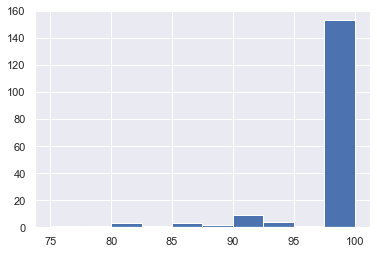

In [46]:
plt.figure(figsize=(10,8))
plt.hist(profitable['Squeeze Risk']);

Most gains > 10% occur at 100 percent Squeeze Risk in our top10 Squeeze Risk dataset

In [47]:
pd.DataFrame(profitable[['Squeeze Risk']].value_counts(), columns=['count'])

,count
Squeeze Risk,
100.0,143
97.5,10
90.0,9
92.5,4
80.0,3
85.0,3
87.5,2
75.0,1
77.5,1


In [48]:
pd.DataFrame(profitable.groupby('Squeeze Risk')['squeeze_return'].mean())

,squeeze_return
Squeeze Risk,
75.0,0.485000
77.5,0.133000
80.0,0.208000
82.5,0.135000
85.0,0.170333
87.5,0.144000
90.0,0.138222
92.5,0.165500
95.0,0.143000


Seems to be an outlier at 75% Squeeze Risk

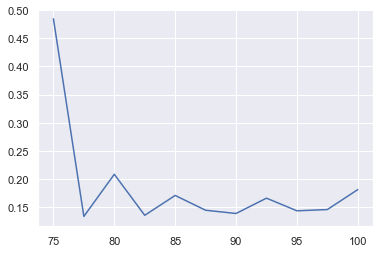

In [49]:
plt.figure(figsize=(10,8))
plt.plot(profitable.groupby('Squeeze Risk')['squeeze_return'].mean());

In [50]:
# check outlier at 75%
profitable[profitable['Squeeze Risk'] == 75]


,date,symbol,Open,High,Low,Close,Volume,vwap,prev_close,prev_vwap,Offer Rate,Bid Rate,Last Rate,Short Momentum,Short Interest,ShortInterestNotional,ShortInterestPct,S3Float,S3SIPctFloat,IndicativeAvailability,DaysToCover10Day,DaysToCover30Day,DaysToCover90Day,Crowded Score,Squeeze Risk,squeeze_return,profitable
2331,2021-12-08,ISIG,12.8,24.85,12.16,19.110001,68130229,19.980099,10.38,10.749066,12.57,9.66,5.39,30.0,27321.0,283591.98,0.0296,949450.0,0.0288,29586.0,0.0,0.01,0.02,15.0,75.0,0.485,1


ISIG had a high of $24.85 on December 8th for an opne of $12.80

In [51]:
profitable.shape

(178, 27)

In [52]:
# 248 trading days
len(set(df_s3_21_us_filtered.index))


248

In [53]:
# range of Squeeze Risks for potential trade returns > 10%
profitable['Squeeze Risk'].min(), profitable['Squeeze Risk'].max()


(75.0, 100.0)

In [54]:
# number of data points with Squeeze Risk >= 75%
df_s3_21_us_filtered[df_s3_21_us_filtered['Squeeze Risk'] >= 75].shape[0]


11673

In [55]:
# from the daily top 10 S3 Squeeze risk percentage that reach at least 10% above the open
df_top10['profitable'].value_counts()[1]/df_top10.shape[0]


0.0728910728910729

7.3% in our top 10 dataset will reach 10% above the open. Our dataset is unbalanced.

This data would be useful as part of a model but it would be unlikely to yield a good model on its own.

## Feature Importance

In [56]:
#
# Lets do a quick xgboost model with our data
# convert our target profitabe to int
df_top10['profitable'] = df_top10['profitable'].astype(int)

In [57]:
df_top10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2442 entries, 0 to 2441
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    2442 non-null   object 
 1   symbol                  2442 non-null   object 
 2   Open                    2442 non-null   float64
 3   High                    2442 non-null   float64
 4   Low                     2442 non-null   float64
 5   Close                   2442 non-null   float64
 6   Volume                  2442 non-null   object 
 7   vwap                    2442 non-null   float64
 8   prev_close              2442 non-null   float64
 9   prev_vwap               2442 non-null   float64
 10  Offer Rate              2442 non-null   float64
 11  Bid Rate                2442 non-null   float64
 12  Last Rate               2442 non-null   float64
 13  Short Momentum          2435 non-null   float64
 14  Short Interest          2442 non-null   

In [58]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


In [61]:
# X = df_top10.copy()[['Open','prev_close','prev_vwap','ShortInterestPct','S3SIPctFloat','Crowded Score','Squeeze Risk']]
X = df_top10.copy()[['Open','prev_close','prev_vwap','Offer Rate',
 'Bid Rate',
 'Last Rate',
 'Short Momentum',
 'Short Interest',
 'ShortInterestNotional',
 'ShortInterestPct',
 'S3Float',
 'S3SIPctFloat',
 'IndicativeAvailability',
 'DaysToCover10Day',
 'DaysToCover30Day',
 'DaysToCover90Day',
 'Crowded Score',
 'Squeeze Risk']]
X.head()

,Open,prev_close,prev_vwap,Offer Rate,Bid Rate,Last Rate,Short Momentum,Short Interest,ShortInterestNotional,ShortInterestPct,S3Float,S3SIPctFloat,IndicativeAvailability,DaysToCover10Day,DaysToCover30Day,DaysToCover90Day,Crowded Score,Squeeze Risk
0,21.160000,21.190001,21.149408,11.33,8.54,13.88,0.00,9575717.6,2.029095e+08,0.4609,30351942.6,0.3155,0.0,7.460554,6.776367,7.998541,90.0,100.0
1,17.059999,17.120001,17.185627,13.58,10.40,13.75,2.96,19792992.7,3.388560e+08,0.2857,89083420.7,0.2222,0.0,7.981142,9.032790,7.064581,92.5,100.0
2,15.450000,15.380000,14.997252,3.33,2.40,2.02,4.50,1038111.0,1.596615e+07,0.2083,6021385.0,0.1724,10563000.0,0.887518,1.354603,1.632401,57.5,100.0
3,114.690002,113.360001,114.886139,58.83,47.00,58.02,1.26,8307969.5,9.417914e+08,0.3323,33309156.5,0.2494,0.0,1.885515,2.233313,4.117996,87.5,100.0
4,41.599998,41.880001,41.894508,0.30,0.15,0.30,0.00,5843457.4,2.447240e+08,0.2678,27664096.4,0.2112,39771.0,14.457705,18.382069,18.579619,80.0,100.0


In [62]:
# lets normalize price values from Open and change percent values to the same scale
X['prev_close'] = X['prev_close']/X['Open']
X['prev_vwap'] = X['prev_vwap']/X['Open']
X['ShortInterestPct'] = X['ShortInterestPct']*100
X['S3SIPctFloat'] = X['S3SIPctFloat'] * 100
del X['Open']
X.head()

,prev_close,prev_vwap,Offer Rate,Bid Rate,Last Rate,Short Momentum,Short Interest,ShortInterestNotional,ShortInterestPct,S3Float,S3SIPctFloat,IndicativeAvailability,DaysToCover10Day,DaysToCover30Day,DaysToCover90Day,Crowded Score,Squeeze Risk
0,1.001418,0.999499,11.33,8.54,13.88,0.00,9575717.6,2.029095e+08,46.09,30351942.6,31.55,0.0,7.460554,6.776367,7.998541,90.0,100.0
1,1.003517,1.007364,13.58,10.40,13.75,2.96,19792992.7,3.388560e+08,28.57,89083420.7,22.22,0.0,7.981142,9.032790,7.064581,92.5,100.0
2,0.995469,0.970696,3.33,2.40,2.02,4.50,1038111.0,1.596615e+07,20.83,6021385.0,17.24,10563000.0,0.887518,1.354603,1.632401,57.5,100.0
3,0.988404,1.001710,58.83,47.00,58.02,1.26,8307969.5,9.417914e+08,33.23,33309156.5,24.94,0.0,1.885515,2.233313,4.117996,87.5,100.0
4,1.006731,1.007080,0.30,0.15,0.30,0.00,5843457.4,2.447240e+08,26.78,27664096.4,21.12,39771.0,14.457705,18.382069,18.579619,80.0,100.0


In [63]:
X['Squeeze Risk'].value_counts()

100.0    1366
95.0      172
97.5      167
92.5      162
90.0      151
87.5      131
85.0      107
82.5       65
75.0       42
80.0       31
77.5       31
72.5       11
70.0        3
67.5        3
Name: Squeeze Risk, dtype: int64

Target is our >10% open to high label

In [64]:
y = df_top10['profitable']

In [65]:
# Split training with 20% test set and maintain positive ratio.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2, stratify=y)

In [66]:
X_train.shape, X_test.shape

((1953, 17), (489, 17))

In [67]:
xgb = XGBClassifier(booster='gbtree',
objective='binary:logistic', max_depth=6,
learning_rate=0.1, n_estimators=100,
random_state=2, n_jobs=-1, scale_pos_weight=13, use_label_encoder=False, eval_metric='logloss')

In [68]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=13, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [69]:
y_pred = xgb.predict(X_test)

In [70]:
score = accuracy_score(y_pred, y_test)

In [71]:
print('Score: ' + str(score))

Score: 0.8936605316973415


Accuracy of 89% kind of meaningless in such an unbalanced dataset.

In [72]:
# Confusion matrix code
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False
# MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## Confusion Matrix

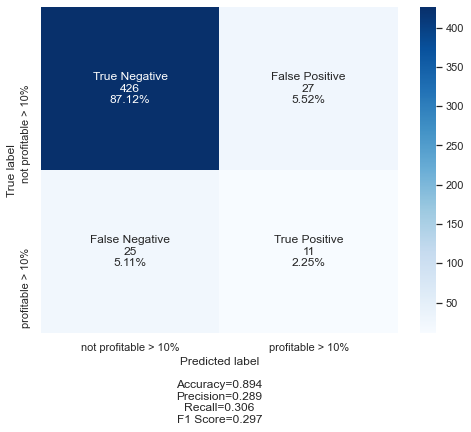

In [73]:
cm1=confusion_matrix(y_test, y_pred)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'not profitable > 10%','profitable > 10%']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories,
                      figsize=(8,6), 
                      cmap='Blues')


As expected, poor metrics with this limited S3 data and the unbalance.

What we are really interested in is the feature importance that our model came up with.

## Feature importance

In [74]:
xgb.feature_importances_

array([0.04025586, 0.07743476, 0.03004097, 0.05922084, 0.02786616,
       0.04044219, 0.03646403, 0.04996768, 0.05421074, 0.05780815,
       0.        , 0.03577696, 0.24009986, 0.06576711, 0.04685961,
       0.03901406, 0.09877095], dtype=float32)

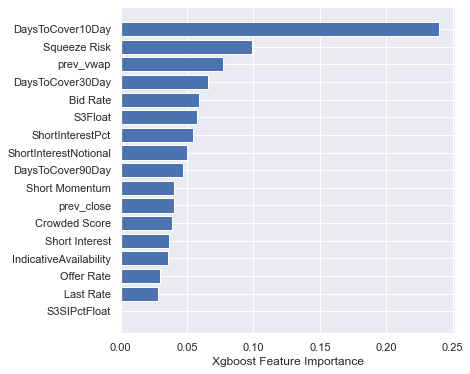

In [82]:
sorted_idx = xgb.feature_importances_.argsort()
plt.figure(figsize=(6,6))
plt.barh(np.array(list(X))[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance");

In this preliminary model, DaysToCover10Day is the most important feature by far.  More than double the Squeeze Risk importance which would be expected at the top.

Would need to explore this further.

S3SIPctFloat has 0 importance, must be highly correlated to another feature in our top 10 Squeeze Risk dataset.

In [86]:
X[['S3SIPctFloat','ShortInterestPct']].corr()

,S3SIPctFloat,ShortInterestPct
S3SIPctFloat,1.000000,0.986361
ShortInterestPct,0.986361,1.000000


Confirmed our tree model trigerred on the ShortInterestPct feature which is 99% correlated with S3SIPPctFloat.

## Conclusion

S3 data is a valuable dataset.  The S3 short data could be used in alpha factor research and contribute to models.  The accurate float data by itself is valuable as float affects the way a stock trades.

Finviz Elite short interest data seem to be highly correlated to S3 short data and the stated increased accuracy is not obvious.  S3 data includes other proprietary features like Squeeze Risk which provide additional information value.

This is just an initial look at the S3 data, more analysis is warranted.